In [1]:
#%load_ext line_profiler
#%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
import util
import models
import platform

from os.path import expanduser
from os import path
import logging

# logging.basicConfig(level=logging.DEBUG)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import preprocess

import numpy as np
from scipy.io import loadmat

from dstools import plot

LOCAL = platform.system() == 'Darwin'

In [49]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [54]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [14]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 5

In [16]:
n_spikes = 20000

min_amplitude = 5
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [20]:
templates, _ = preprocess(CONFIG, gt,
                          path_to_standarized,
                          chosen_templates)

100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


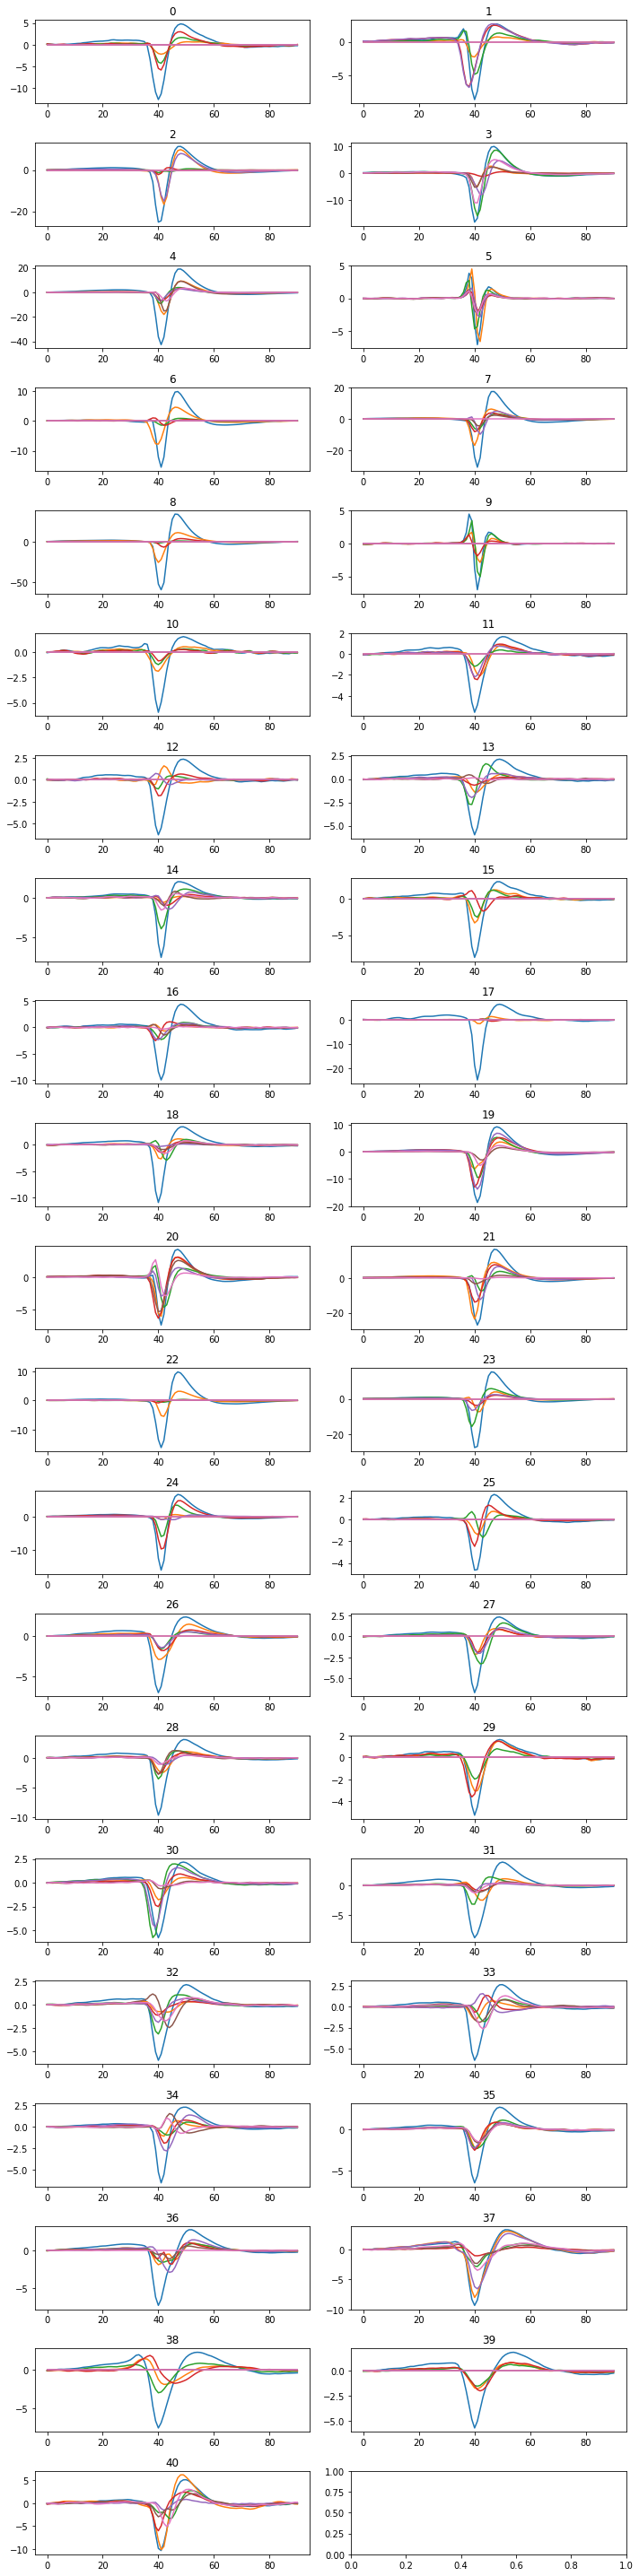

In [29]:
plot.grid_from_array(templates, axis=0, figsize=(10, 40),
                     max_cols=2)

In [ ]:
def spike_amplitudes_from_spikes(spikes):
    abs_value = np.abs(spikes)
    
    amplitudes = np.max(abs_value, axis=(1, 2))
    main_channels = np.argmax(np.max(abs_value, axis=1), axis=1)

    return amplitudes, main_channels

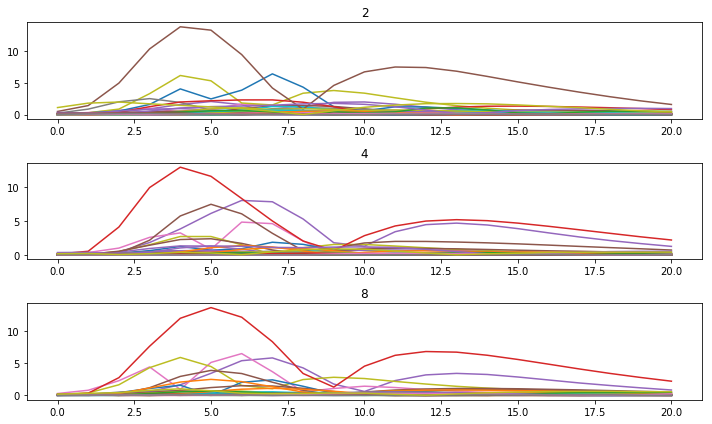

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
plot.grid_from_array(np.abs(se.templates), axis=0, elements=[2, 4, 8])

In [10]:
templates = np.copy(se.templates)
templates = np.concatenate((templates, np.zeros((49, 21, 1))), axis=2)

In [11]:
amps, main_channels = spike_amplitudes_from_spikes(se.templates)

In [12]:
print(amps[2], main_channels[2])

13.871453 25


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


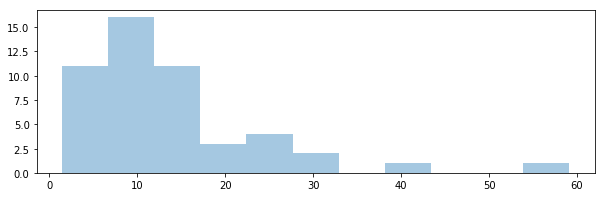

In [13]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

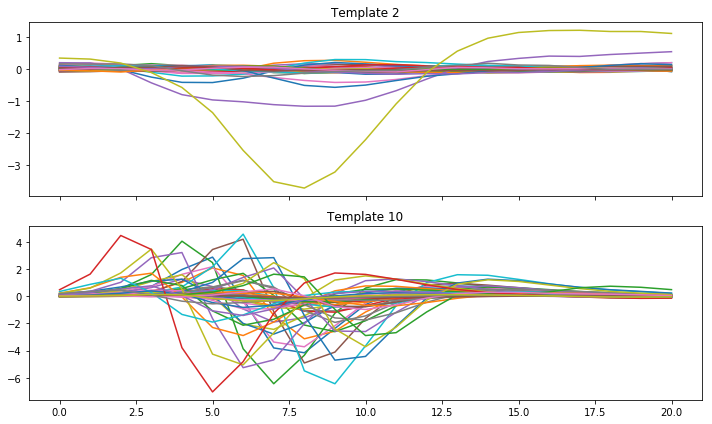

In [14]:
# this looks wrong
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[2, 10])

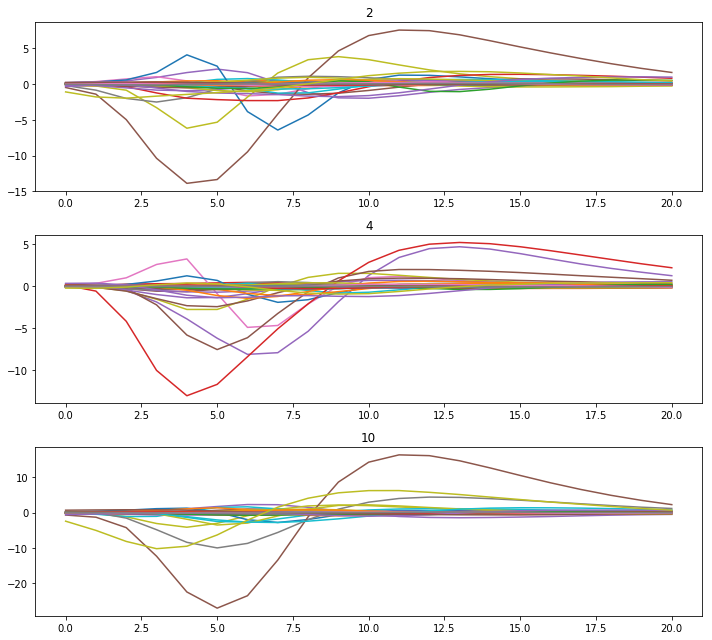

In [15]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(se.templates, axis=0, elements=[2, 4, 10])

In [16]:
from yass.geometry import make_channel_index

In [17]:
ch_index = make_channel_index(re.neigh_matrix, re.geom)

In [18]:
n_templates, waveform_length, n_channels = templates.shape

small_templates = np.empty((n_templates, waveform_length, 7))

for i in range(n_templates):
    main_channel = main_channels[i]
    neighbors = ch_index[main_channel]
    small_templates[i] = templates[i][:, neighbors]

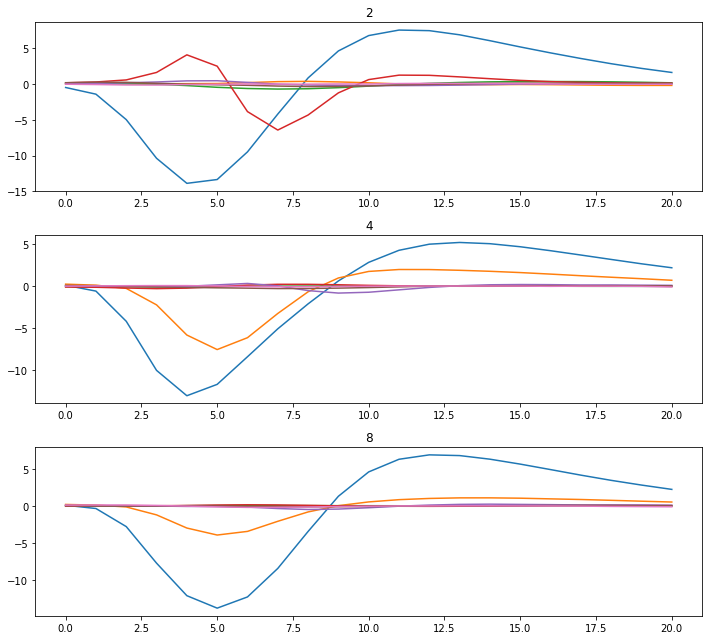

In [19]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid_from_array(small_templates, axis=0, elements=[2, 4, 8])

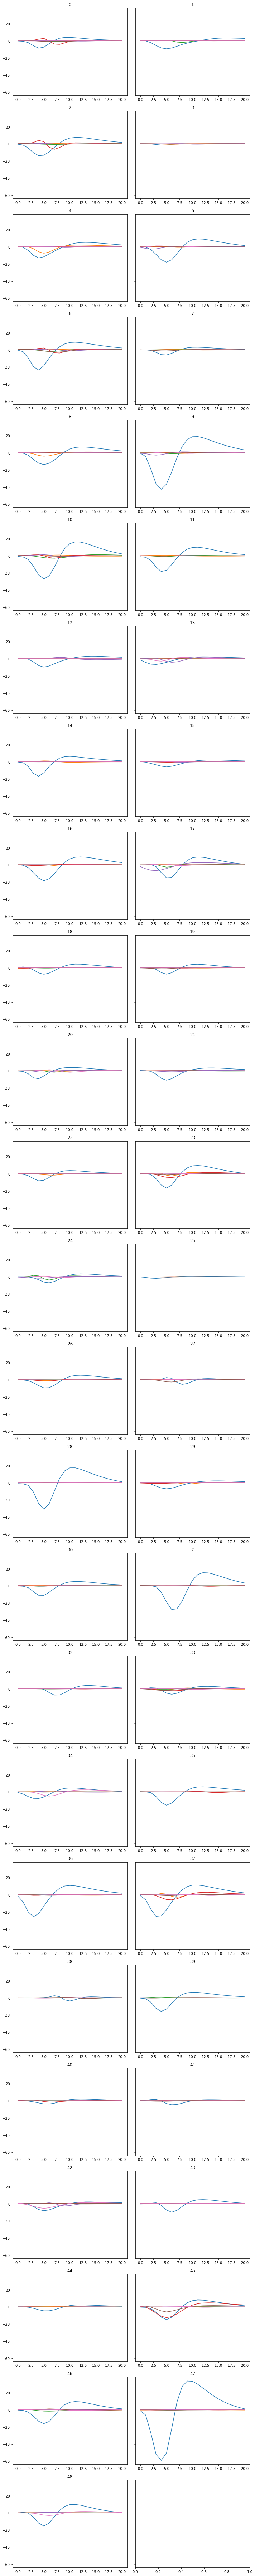

In [20]:
plt.rcParams['figure.figsize'] = (10, 100)
plot.grid_from_array(small_templates, axis=0, max_cols=2, sharey=True)

## Generating training data

In [30]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True)

100%|██████████| 12/12 [00:46<00:00,  3.87s/it]


In [31]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(260104, 31, 7)
	triage:(40016, 31, 7)
	autoencoder:(196176, 31)


In [32]:
print(x_ae.shape, y_ae.shape)

(196176, 31) (196176, 31)


In [33]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

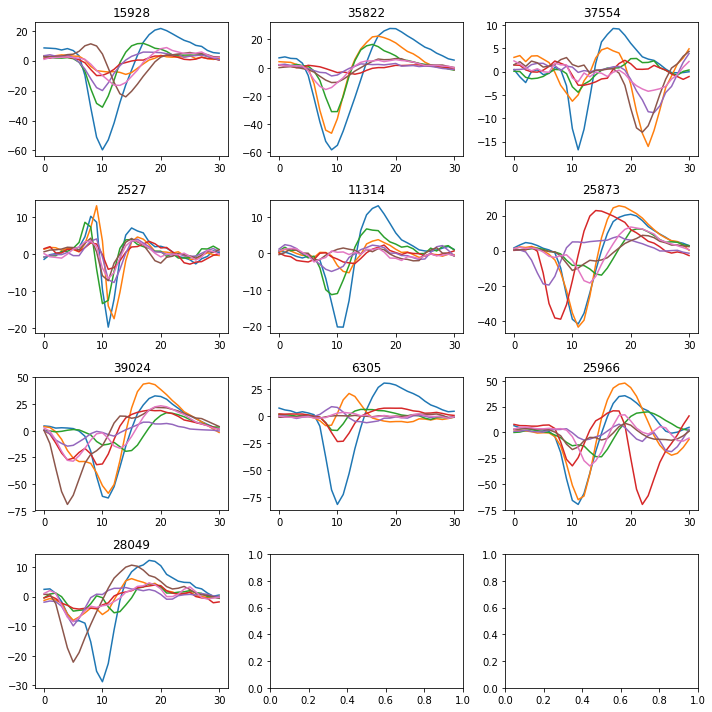

In [34]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_positive, axis=0, elements=10)

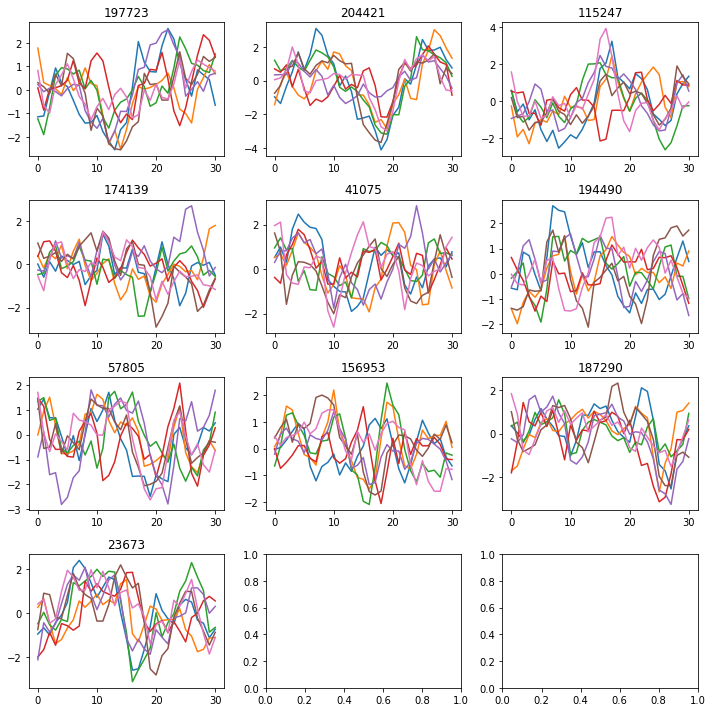

In [35]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_detect_negative, axis=0, elements=10)

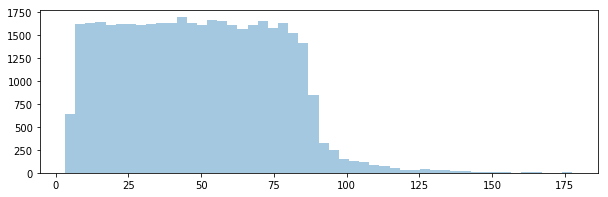

In [36]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

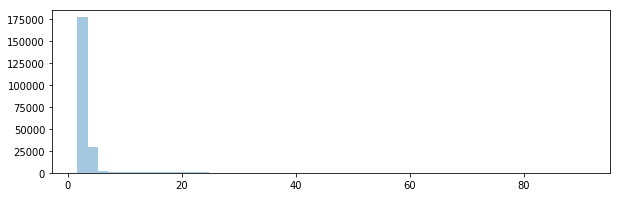

In [37]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

In [38]:
x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

In [39]:
print(x_triage_positive.shape, x_triage_negative.shape)

(20008, 31, 7) (20008, 31, 7)


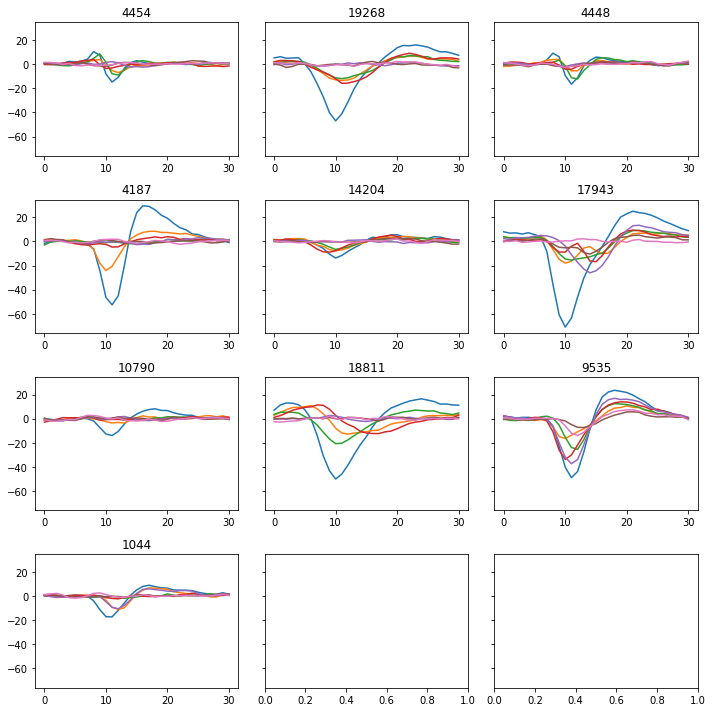

In [40]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_positive, axis=0, elements=10, sharey=True)

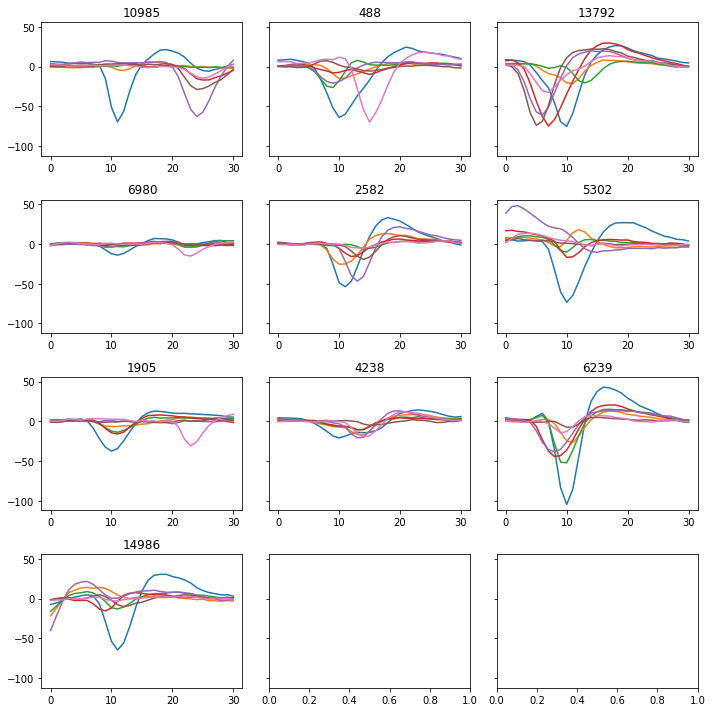

In [41]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(x_triage_negative, axis=0, elements=10, sharey=True)

# Training

In [65]:
n_iter = 500

## Detector training

In [35]:
detect_name = path.join(path_to_here, 'models', 'detect-'+util.directory()+'.ckpt')
filters_detect = [8, 4]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

Tr loss: 0.016897175, Val loss: 0.018748468: 100%|██████████| 500/500 [00:04<00:00, 110.98it/s]


## Triage training

In [66]:
triage_name = path.join(path_to_here, 'models', 'triage-'+util.directory()+'.ckpt')
#filters_triage = [8, 4]
filters_triage = [12, 6]

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)


Tr loss: 0.3413514, Val loss: 0.35202512:  96%|█████████▌| 478/500 [00:09<00:00, 48.62it/s]


Tr loss: 0.3413514, Val loss: 0.35202512: 100%|██████████| 500/500 [00:10<00:00, 48.32it/s]

## Autoencoder training

In [37]:
ae_name = path.join(path_to_here, 'models', 'ae-'+util.directory()+'.ckpt')

_, waveform_length = x_ae.shape

encoder = AutoEncoder(ae_name, waveform_length, n_features=3)
encoder.fit(x_ae)

# Evaluation

## Detect evaluation

In [38]:
y_pred = detector.predict(detector.x_test)
y_true = detector.y_test

print(metrics.classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     65894
        1.0       1.00      0.99      1.00     12138

avg / total       1.00      1.00      1.00     78032



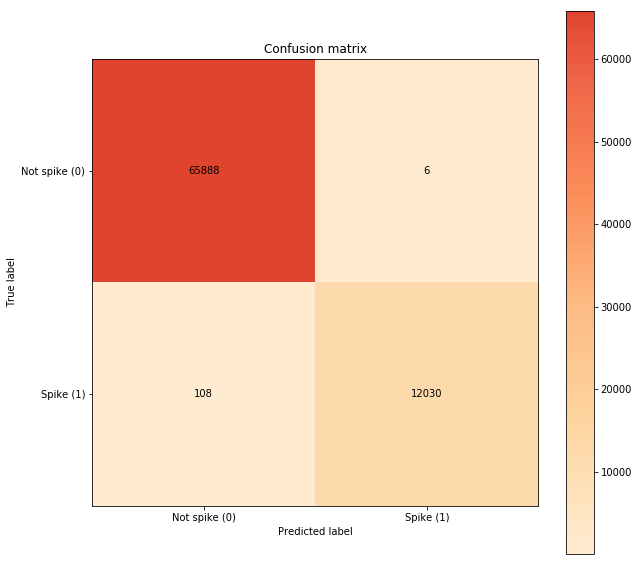

In [39]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Not spike (0)', 'Spike (1)'])

In [40]:
fn_idx = np.logical_and(y_true == NeuralNetDetector.SPIKE, y_pred == NeuralNetDetector.NOT_SPIKE)
fp_idx = np.logical_and(y_true == NeuralNetDetector.NOT_SPIKE, y_pred == NeuralNetDetector.SPIKE)

fns = detector.x_test[fn_idx]
fps = detector.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


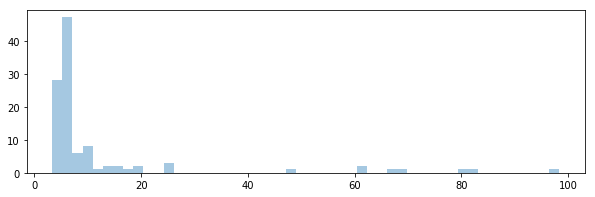

In [41]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


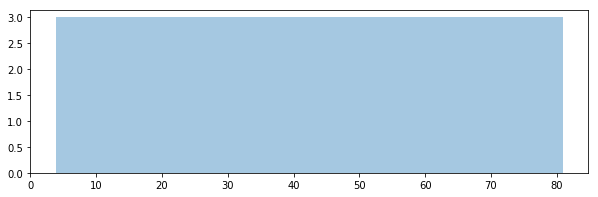

In [42]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

## Triage evaluation

In [60]:
y_pred = triage.predict(triage.x_test)
y_true = triage.y_test

print(metrics.classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.94      0.96      6011
        1.0       0.94      0.99      0.97      5994

avg / total       0.97      0.97      0.97     12005



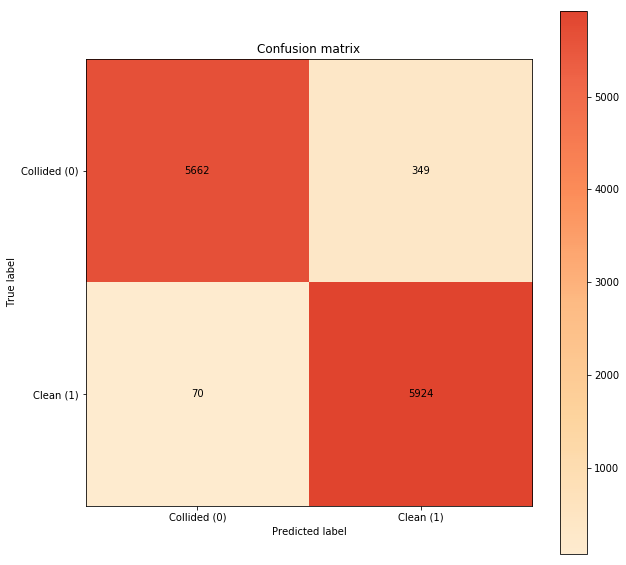

In [63]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Collided (0)', 'Clean (1)'],
                        normalize=False)

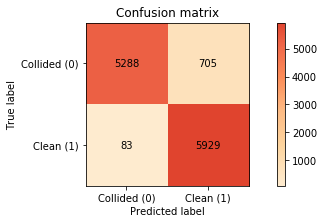

In [50]:
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Collided (0)', 'Clean (1)'],
                        normalize=False)

In [45]:
fn_idx = np.logical_and(y_true == NeuralNetTriage.CLEAN, y_pred == NeuralNetTriage.COLLIDED)
fp_idx = np.logical_and(y_true == NeuralNetTriage.COLLIDED, y_pred == NeuralNetTriage.CLEAN)

fns = triage.x_test[fn_idx]
fps = triage.x_test[fp_idx]

fns_amps = np.max(np.abs(fns), axis=(1, 2))
fps_amps = np.max(np.abs(fps), axis=(1, 2))

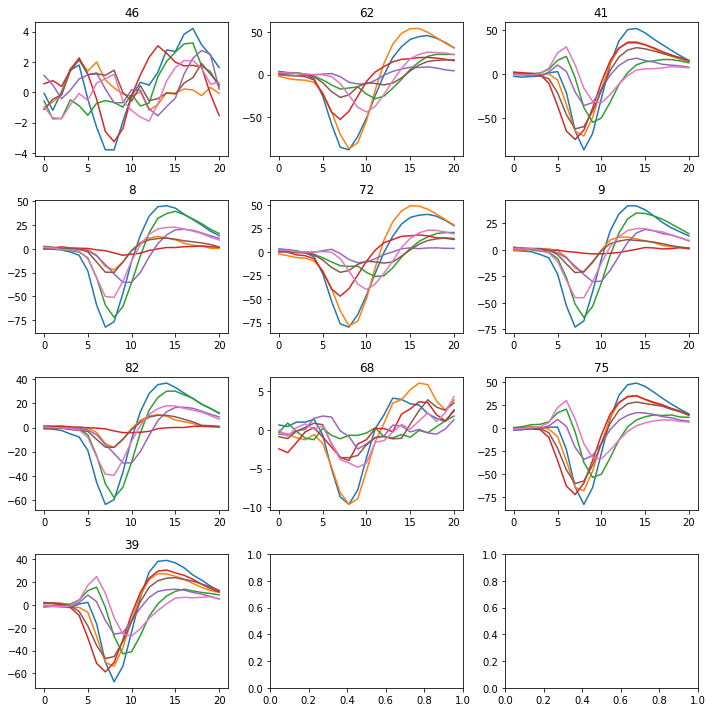

In [46]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(fns, axis=0, elements=10)

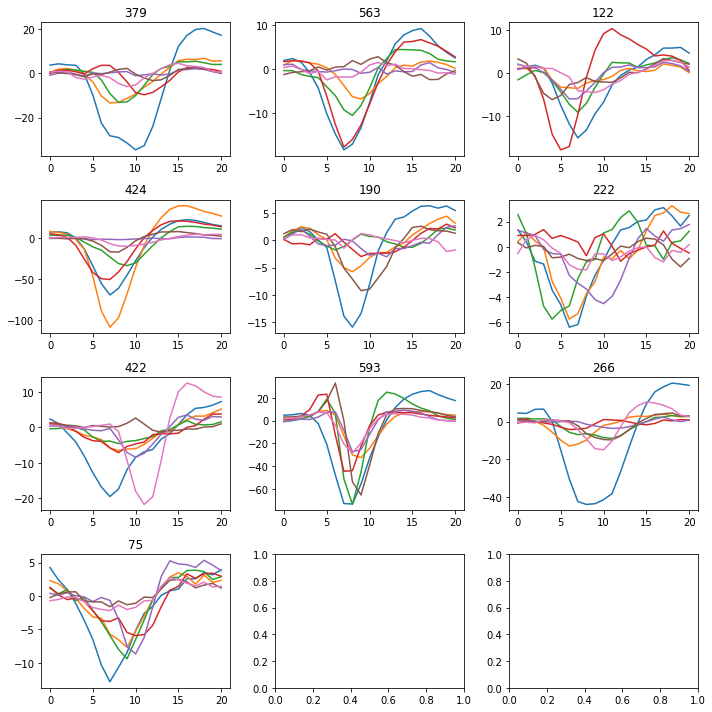

In [47]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid_from_array(fps, axis=0, elements=10)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


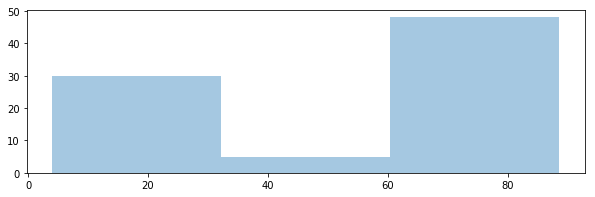

In [48]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fns_amps, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


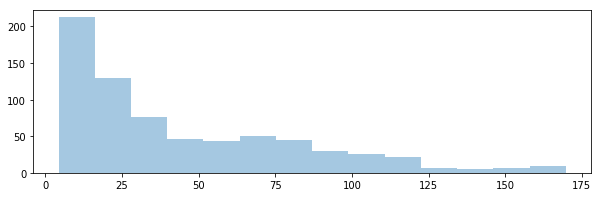

In [49]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(fps_amps, kde=False)

# Running detection step

In [50]:
from copy import copy

yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

cfg = copy(CONFIG._data)

# cfg['detect']['neural_network_detector']['filename'] = detect_name
# cfg['detect']['neural_network_triage']['filename'] = triage_name
# cfg['detect']['neural_network_autoencoder']['filename'] = ae_name

output_dir = 'tmp'

cfg.pop('channel_groups')
cfg.pop('channel_index')
cfg.pop('geom')
cfg.pop('neigh_channels')
cfg.pop('spike_size')

yass.set_config(cfg)

In [51]:
CONFIG = read_config()

print(CONFIG['detect']['neural_network_detector']['filename'])
print(CONFIG['detect']['neural_network_triage']['filename'])
print(CONFIG['detect']['neural_network_autoencoder']['filename'])

/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt
/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt
/home/Edu/dev/yass/src/yass/assets/models/ae_nn1.ckpt


In [52]:
(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

In [53]:
_, spikes_clear, spikes_all  = detect.run(path_to_standarized, standarized_params, whiten_filter)

/home/Edu/dev/yass/src/yass/neuralnetwork/model_triage.py:73: UserWarning: Network n_neighbors (7) does not match n_neighbors on input_tensor (19), using only the first n_neighbors from the input_tensor
  input_tensor.shape[2]))
100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


In [54]:
print(f'All spikes: {spikes_all.shape[0]:,}\nClear spikes: {spikes_clear.shape[0]:,}')

All spikes: 1,440,596
Clear spikes: 105,935


# Predict

In [55]:
# output_dir = 'tmp/'

# (path_to_standarized,
#  standarized_params,
#  whiten_filter) = preprocess.run(output_directory=output_dir,
#                                  if_file_exists='skip')

In [56]:
# explorer_std = RecordingExplorer(path_to_standarized,
#                                  path_to_geom=None,
#                                  spike_size=15, neighbor_radius=70)

In [57]:
# _data = explorer_std.reader.data
# window_size = 10000
# idx = gt[105963, 0]
# data = _data[idx-window_size:idx+window_size, :]

## Detect predict

In [58]:
# output_names = ('spike_index', 'waveform', 'probability')

# (spike_index, waveform,
#  proba) = detector.predict(data, output_names=output_names)

In [59]:
# _ = plt.plot(data)

In [60]:
# _ = plt.plot(waveform[0, :])

In [61]:
# _ = plt.plot(proba)

## Triage predict

In [62]:
# # to_triage = waveform[:, :, :x_triage.shape[2]]
# to_triage = small_templates

In [63]:
# idx_clean = triage.predict(to_triage)

In [64]:
# not_clean = np.where(~idx_clean)[0]

In [65]:
# plt.rcParams['figure.figsize'] = (10, 10)
# plot.grid(small_templates, axis=0, elements=not_clean, sharey=False)

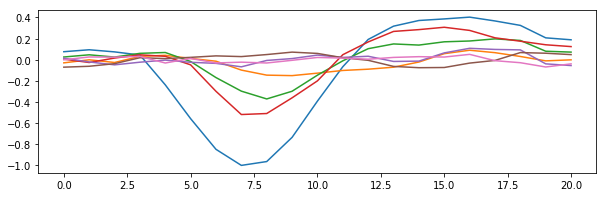

In [76]:
amp = np.max(np.abs(x_detect[100]))
plt.plot(x_detect[100]/amp)